In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, mean_squared_error,mean_absolute_percentage_error,r2_score
import tensorflow as tf
import talib
from tensorflow import keras
from sklearn.pipeline import make_pipeline
from tensorflow.keras import regularizers

2022-04-09 02:03:30.164314: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-09 02:03:30.164349: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
data=yf.download('0700.hk')

[*********************100%***********************]  1 of 1 completed


In [3]:
data['6day MA'] = data['Close'].rolling(window = 6).mean()
data['12day MA'] = data['Close'].rolling(window = 12).mean()
data['RSI'] = talib.RSI(data['Close'].values, timeperiod = 7)
data['%R5'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 5)
data['%R10'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 10)
data['MI6']=talib.MOM(data['Close'],timeperiod=6)
data['MI12']=talib.MOM(data['Close'],timeperiod=12)
macd, macdsignal, macdhist = talib.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
data['EMA12']=talib.EMA(data['Close'], timeperiod=12)
data['EMA26']=talib.EMA(data['Close'],timeperiod=26)
data['MACD']=macd
data['TR']=talib.TRANGE(data['High'],data['Low'],data['Close'])
data['OSC6']=talib.CMO(data['Close'], timeperiod=6)
data['OSC12']=talib.CMO(data['Close'], timeperiod=12)
data['Prediction']=data['Close'].shift(-1)
data.dropna(inplace=True)

In [4]:
# data=data[data.columns[list(backwardModel.k_feature_idx_)]]
data['Prediction']=data['Close'].shift(-1)
data.dropna(inplace=True)
data_val=data[-100:]
data=data[:-100]
data_val.tail()

,Open,High,Low,Close,Adj Close,Volume,6day MA,12day MA,RSI,%R5,%R10,MI6,MI12,EMA12,EMA26,MACD,TR,OSC6,OSC12,Prediction
Date,,,,,,,,,,,,,,,,,,,,
2022-03-30,383.000000,388.600006,380.200012,380.600006,380.600006,26951872,372.600001,369.333333,52.979983,-21.276592,-43.726231,-7.399994,48.800018,375.239148,389.873328,-14.634180,11.399994,9.571940,-4.034221,374.200012
2022-03-31,382.399994,382.399994,372.600006,374.200012,374.200012,14589554,370.133336,375.683334,48.946234,-38.297850,-55.893518,-14.799988,76.200012,375.079281,388.712342,-13.633061,9.799988,-0.625479,-8.055103,378.799988
2022-04-01,367.000000,378.799988,362.200012,378.799988,378.799988,14496674,372.266668,376.666667,52.010099,-28.323747,-47.148318,12.799988,11.799988,375.651697,387.978094,-12.326396,16.599976,6.851465,-4.618128,390.000000
2022-04-04,388.799988,391.000000,383.799988,390.000000,390.000000,15665556,377.866669,376.666667,58.999512,-3.472224,-25.855522,33.600006,0.000000,377.859129,388.127864,-10.268736,12.200012,23.466838,3.532026,381.000000
2022-04-06,383.000000,385.000000,380.000000,381.000000,381.000000,17127923,380.300003,376.666667,51.911489,-34.722237,-42.965786,14.600006,0.000000,378.342340,387.599874,-9.257535,10.000000,5.346744,-3.086421,374.399994


In [5]:
sc = MinMaxScaler(feature_range = (-1, 1))
X=sc.fit_transform(data.drop('Prediction',1))
# X=data.drop('Prediction',1)
Y = data["Prediction"].values.reshape(-1,1)


/tmp/ipykernel_2123/543750826.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X=sc.fit_transform(data.drop('Prediction',1))


/home/gordon/anaconda3/envs/FYP/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


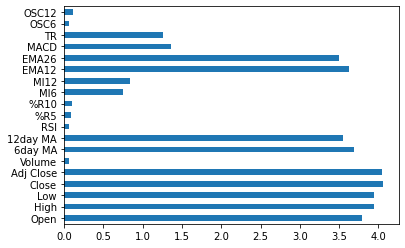

In [6]:
from sklearn.feature_selection import mutual_info_regression
importance=mutual_info_regression(X,Y)
feature_importances=pd.Series(importance,data.columns[0:len(data.columns)-1])
feature_importances.plot(kind="barh")
plt.show()

In [7]:
# X=sc.fit_transform(data.drop(['Prediction','OSC12','OSC6','MI12','MI6','Volume','%R10','%R5','RSI'],1))
# Y=np.array(data["Close"])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(3843, 1, 19) (3843, 1) (427, 1, 19) (427, 1)


In [8]:
model_tech = keras.Sequential()
model_tech.add(keras.layers.LSTM(
  units=128,
  input_shape=(X_train.shape[1], X_train.shape[2]),
    return_sequences=True,
    kernel_regularizer=regularizers.l2(0.01)
))
model_tech.add(keras.layers.LSTM(units=64))
model_tech.add(keras.layers.Dense(units=64))
model_tech.add(keras.layers.Dense(units=1))
model_tech.compile(
  loss='mean_squared_error',
  optimizer=keras.optimizers.Adam(0.001)
)

2022-04-09 02:03:32.683924: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-09 02:03:32.684146: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-09 02:03:32.684179: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-04-09 02:03:32.684204: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-04-09 02:03:32.684227: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

In [9]:
history_tech=model_tech.fit(
    X_train, y_train,
    epochs=300,
    batch_size=5,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)
y_pred = model_tech.predict(X_test)

Epoch 1/300
692/692 [==============================] - 5s 4ms/step - loss: 11465.3604 - val_loss: 634.9933
Epoch 2/300
692/692 [==============================] - 2s 3ms/step - loss: 264.6237 - val_loss: 115.5364
Epoch 3/300
692/692 [==============================] - 3s 4ms/step - loss: 118.4995 - val_loss: 66.2364
Epoch 4/300
692/692 [==============================] - 2s 3ms/step - loss: 79.3800 - val_loss: 60.5150
Epoch 5/300
692/692 [==============================] - 2s 3ms/step - loss: 64.6877 - val_loss: 60.3263
Epoch 6/300
692/692 [==============================] - 2s 3ms/step - loss: 57.5345 - val_loss: 57.4115
Epoch 7/300
692/692 [==============================] - 2s 3ms/step - loss: 53.3343 - val_loss: 55.8317
Epoch 8/300
692/692 [==============================] - 2s 3ms/step - loss: 50.8029 - val_loss: 56.2604
Epoch 9/300
692/692 [==============================] - 2s 3ms/step - loss: 49.2099 - val_loss: 57.1421
Epoch 10/300
692/692 [==============================] - 2s 3ms/ste

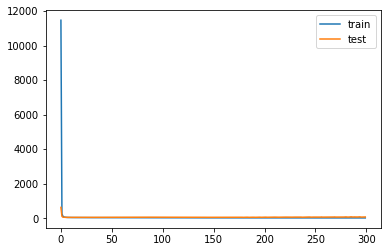

In [10]:
plt.plot(history_tech.history['loss'], label='train')
plt.plot(history_tech.history['val_loss'], label='test')
plt.legend()

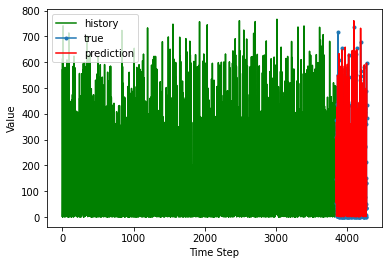

In [11]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()

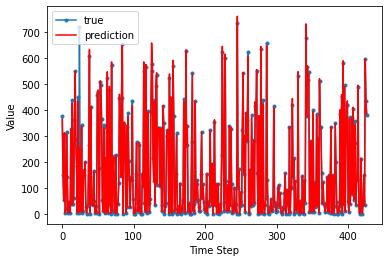

In [12]:
# y_test = sc.inverse_transform(y_test)
# y_pred = sc.inverse_transform(y_pred)
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [13]:
r2_score(y_test,y_pred)

0.9834944266022907

In [14]:
mean_absolute_percentage_error(y_test,y_pred)

0.12256561646791175

In [15]:
mean_squared_error(y_test,y_pred,squared=False)

23.82584391492501

In [16]:
x_val=data_val.drop(['Prediction'],1)
y_val=data_val['Prediction']
x_val=sc.transform(x_val).reshape(x_val.shape[0],1,x_val.shape[1])
y_val_pred=model_tech.predict(x_val)

/tmp/ipykernel_2123/2648236666.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_val=data_val.drop(['Prediction'],1)


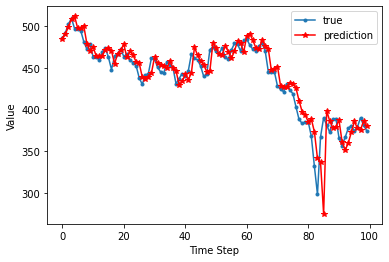

In [17]:
plt.plot(y_val.values, marker='.', label="true")
plt.plot(y_val_pred, 'r', marker='*',label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()

In [18]:
r2_score(y_val,y_val_pred)

0.8321733055456825

In [19]:
mean_absolute_percentage_error(y_val,y_val_pred)

0.026446645712923596

In [20]:
mean_squared_error(y_val.values,y_val_pred,squared=False)

17.251180011520802